In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

import xspec as x

In [2]:
x.Xset.chatter = 0
#x.Xset.logChatter = 25
logFile = x.Xset.openLog("newLogFile.txt")

# getstats

In [14]:
x.AllData.clear()
x.AllData.removeDummyrsp()
x.AllData.dummyrsp(lowE=0.1, highE=10.0, nBins=100)
x.Xset.addModelString("APEC_TRACE_ABUND", "0")

x.Plot.device = "/xs"

In [313]:
logFile = x.Xset.openLog("newLogFile.txt")

temperatures = np.logspace(np.log10(0.1), np.log10(12), 1001)

telname, t5 = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'
#telname, t5 = 'SRG/eROSITA', 'SRG_eROSITA'
#telname,t5 = 'XMM-Newton/MOS', 'XMM-Newton_MOS'
    
Tt = 1.0
Ab = 1.0
Norm = 1
z = 0
n_H = 0.0

headers = ['Flux', 'Abund', 'T', 'z', 'n_H', 'Chnls', '$E_{min}$', '$E_{max}$', '$E_{sum}$', 'cs', 'ecs', 'rate']
df = pd.DataFrame([], columns = headers)

for Temp in temperatures:
    
    mod = x.Model('phabs*(apec+const*apec)')
    mod.setPars(n_H, Temp, Ab, z, Norm, 1., Temp, 0.0, z, Norm)
    mod(6).values =  "-1, 0.0001, -1, -1, 1, 1"
    mod(7).link = "2"
    mod(9).link = "4"
    mod(10).link = "5"
    #mod = x.Model('apec')
    #mod.setPars(1.0, 0.1, 0., 1)
    
    x.AllModels.show()
    #x.Plot.show()
    #x.AllModels.setEnergies("0.1 10.0 10 log")
    #x.AllModels.setEnergies("reset")
    #x.Plot("model")
    
    if telname == 'Chandra/ACIS-OLD':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telname == 'SRG/eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    elif telname == 'Chandra/ACIS-NEW':
        RMF_NAME = 'telescopes/acis/acisi.rmf'
        ARF_NAME = 'telescopes/acis/acisi_namp_qc.arf'
    elif telname == 'XMM-Newton/MOS':
        RMF_NAME = 'telescopes/xmm-newton/m1_thin1v9q19t5r5_all_15.rsp'
        ARF_NAME = '' 
    
    fs = x.FakeitSettings(response = RMF_NAME, 
                               arf = ARF_NAME, 
                        background = '', 
                          exposure = 40000, 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = True)

    x.AllData.ignore("**-0.7 10.0-**")             # IMPORTANT !
    #x.AllData.show()
    x.AllModels.setEnergies("reset")
    
    x.Plot("data")
    x.Plot.xAxis = "keV"
    xVals = x.Plot.x()
    yVals = x.Plot.y()
         
    x.AllModels.calcFlux('0.7 10.0')
    fluxx = x.AllData(1).flux[0]
    #print('Flux:', fluxx)
    
    #print('Abund:', Ab)
    #print('Temp:', Temp)
    #print('Redshift:', z)
    #print('Absorption:', n_H)    
    
    channels = len(x.AllData(1).noticed)
    #print('Channels:', channels)
    
    ens = x.AllData(1).energies
    e_min = min(ens)[0]
    e_max = max(ens)[1]
    #print('E_min:', e_min)
    #print('E_max:', e_max)
    
    s0 = 0
    s1 = 0
    sm = np.zeros(len(ens))
    for i in ens:
        s0 += i[0]
        s1 += i[1]
        sm[ens.index(i)] = (i[0]+i[1])/2
        #print(s0, s1, sm)
    e_sum = (s0+s1)/2
    #print('E_sum:', e_sum)
    #print('E_sum:', sum(sm))
    
    #print('Sum x:', sum(xVals))
    #print('Sum y:', sum(yVals))
    #print('np.dot', np.dot(xVals, yVals))
    
    #cs = x.AllData(1).rate
    #print('Rate:', cs[2])
    
    #r = x.AllData(1).values
    #print(np.dot(r, sm)*40000)
    
    df2 = pd.DataFrame([[fluxx, Ab, Temp, z, n_H, channels, e_min, e_max, 
                         sum(xVals), sum(yVals), np.dot(xVals, yVals), x.AllData(1).rate[0]]], 
                       columns = headers, index=None)
            
    df = pd.concat([df, df2])

df.to_csv('stats_'+t5+'.dat', sep=' ', header=False, index=False)

<Figure size 640x480 with 0 Axes>

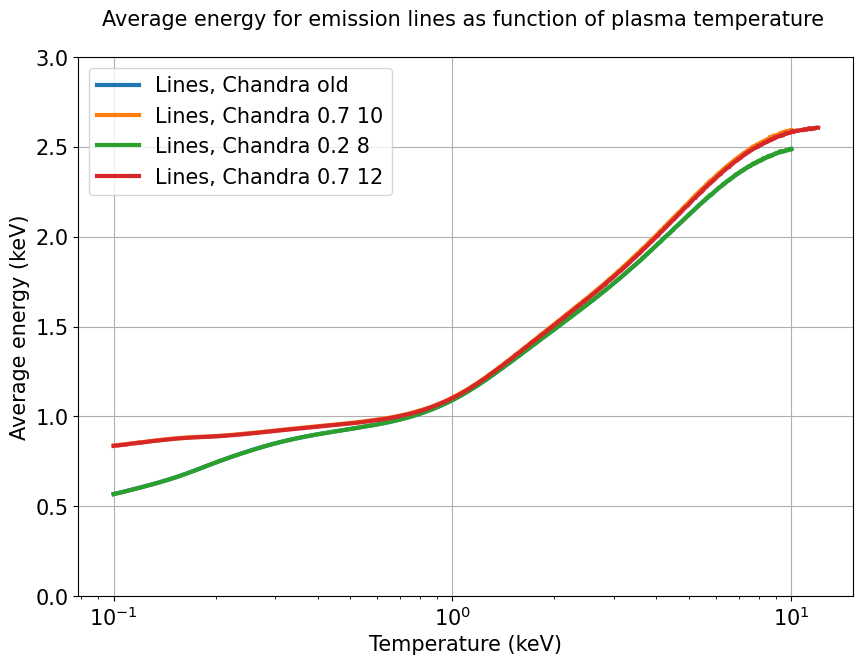

In [329]:
%run -i 'utils/ave_lines.py'

plt.figure(figsize=(10,7))

data_name1 = "data_stats/stats_03.dat"   #'Lines, CH'
data_name2 = "stats444.dat"   #'Lines, CH'
data_name3 = "stats.dat"   #'Lines, CH'
data_name4 = "stats449.dat"   #'Lines, CH'
#data_name5 = "stats_Chandra_ACIS-OLD.dat"

plot_E_T(data_name1, 'Lines', 'Chandra old')
plot_E_T(data_name2, 'Lines', 'Chandra 0.7 10')
plot_E_T(data_name3, 'Lines', 'Chandra 0.2 8')
plot_E_T(data_name4, 'Lines', 'Chandra 0.7 12')
#plot_E_T(data_name5, 'Lines', 'Chandra 0.7 12 ext')

#plt.xlim(0.11, 10)

#plt.xscale('linear')
#add_T(0.5, 1.0, data_name1)

# comment if there is only one E(T)
# this move deletes unique titles
plt.title('Average energy for emission lines as function of plasma temperature \n', fontsize=15)
plt.grid()
#plt.savefig('letter26.10/Fig2.png')
plt.show()

# $\lambda (T)$

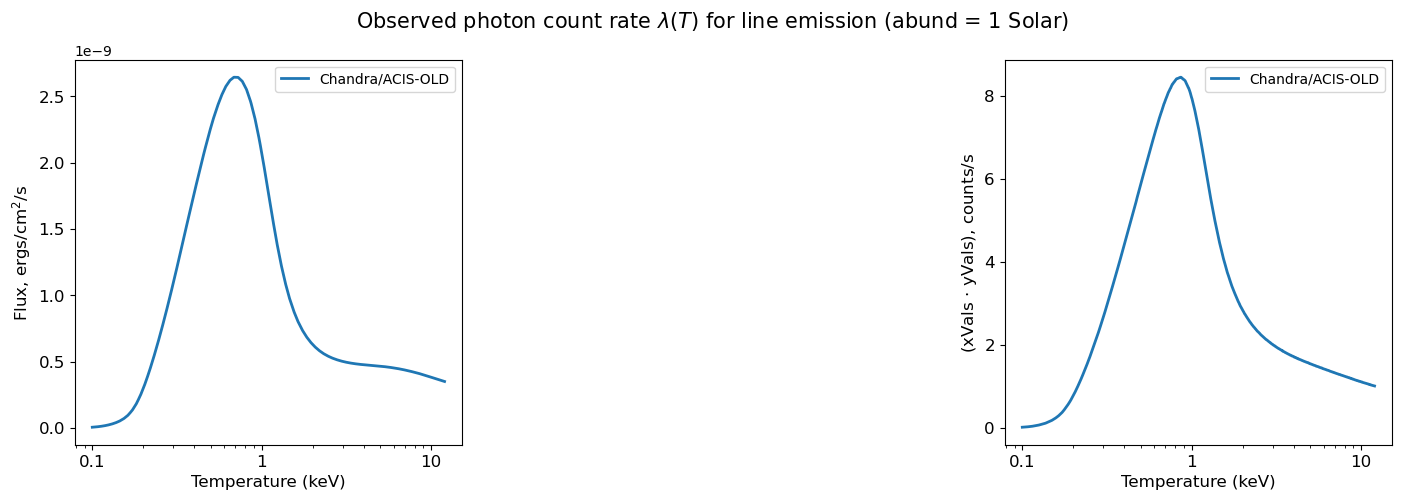

In [301]:
telescope, tt = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'

plt.figure(figsize=(17,5))
plt.suptitle('Observed photon count rate $\lambda(T)$ for line emission (abund = 1 Solar)', fontsize = 15)

def add_fancy():

    plt.xlabel('Temperature (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.legend()

read_lT = pd.read_csv('stats449.dat', header=None, delimiter=' ')
temps1 = read_lT[2].values
flux_photons1 = read_lT[0].values
count_rate1 = read_lT[11].values
npdot1 = read_lT[10].values/read_lT[8].values

plt.subplot(131)
plt.plot(temps1, flux_photons1, label=str(telescope), linewidth=2)
plt.ylabel('Flux, ergs/cm$^2$/s', fontsize = 12)
add_fancy()

plt.subplot(132)
plt.plot(temps1, count_rate1, label=str(telescope), linewidth=2)
plt.ylabel('Count rate, photons/s/keV', fontsize = 12)
add_fancy()

plt.subplot(133)
plt.plot(temps1, npdot1, label=str(telescope), linewidth=2)
plt.ylabel('(xVals $\cdot$ yVals), counts/s', fontsize = 12)
add_fancy()

plt.show()

In [335]:
%run -i 'utils/ave_lines.py'

l_T('Chandra/ACIS-OLD', 1, 'npdot')

7.956566434929505

# $c (T)$

In [304]:
%run -i 'utils/avt_cont.py'

telescope, tt = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'
telescope, tt = 'SRG/eROSITA', 'SRG_eROSITA'
telescope, tt = 'XMM-Newton/MOS', 'XMM-Newton_MOS'

df = pd.DataFrame([])

temps = np.logspace(np.log10(0.1), np.log10(16), 101)
flux_photons = temps * 0
count_rate = temps * 0
npdot = temps * 0

for i in range(0, len(ts1)):
    
    flux_photons[i], count_rate[i], npdot[i] = calc_c_T(temps[i], 0.7, 10.0, telescope, Xplot=False)
    
    df2 = (pd.DataFrame([[temps[i], flux_photons[i], count_rate[i], npdot[i]]], index=None))
    
    df = pd.concat([df, df2])
    
df.to_csv('c(T)/c(T)_'+tt+'.csv', sep=' ', header=False, index=False)

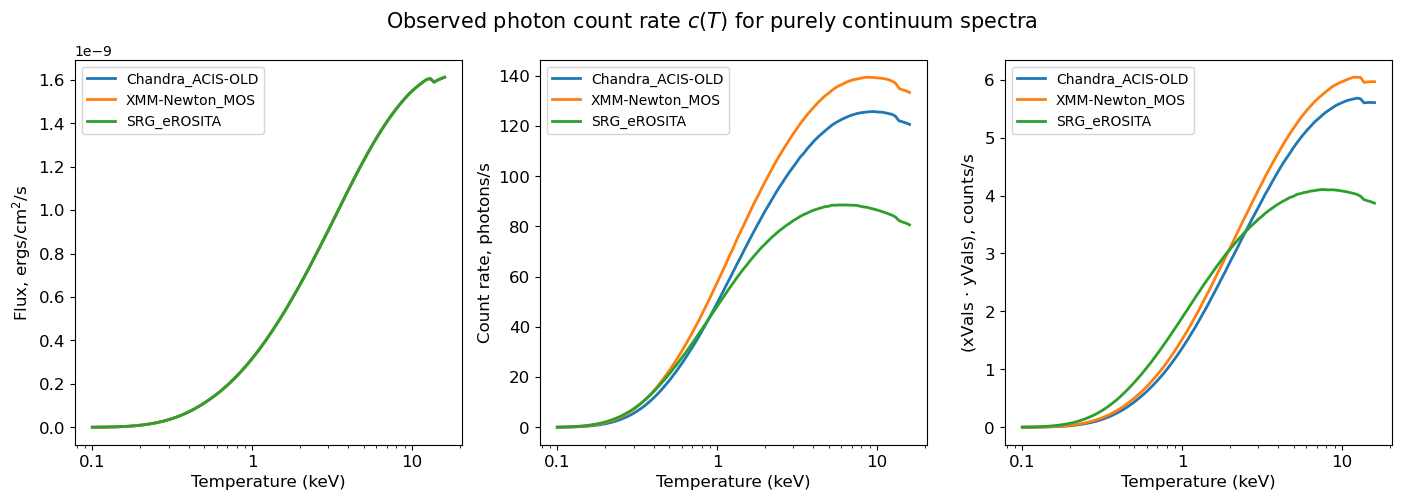

In [305]:
telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

plt.figure(figsize=(17,5))
plt.suptitle('Observed photon count rate $c(T)$ for purely continuum spectra', fontsize = 15)

def add_fancy():

    plt.xlabel('Temperature (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.legend()


for t in telescopes:
    
    read_cT = pd.read_csv('c(T)/c(T)_'+str(t)+'.csv', header=None, delimiter=' ')
    temps = read_cT[0].values
    flux_photons = read_cT[1].values
    count_rate = read_cT[2].values
    npdot = read_cT[3].values
    
    plt.subplot(131)
    plt.plot(temps, flux_photons, label=str(t), linewidth=2)
    plt.ylabel('Flux, ergs/cm$^2$/s', fontsize = 12)
    add_fancy()
    
    plt.subplot(132)
    plt.plot(temps, count_rate, label=str(t), linewidth=2)
    plt.ylabel('Count rate, photons/s', fontsize = 12)
    add_fancy()
    
    plt.subplot(133)
    plt.plot(temps, npdot, label=str(t), linewidth=2)
    plt.ylabel('(xVals $\cdot$ yVals), counts/s', fontsize = 12)
    add_fancy()

plt.show()

In [333]:
%run -i 'utils/avt_cont.py'

c_T('Chandra/ACIS-OLD', 1, 'npdot')

1.3315526005634273

# $ƒ_{line}$

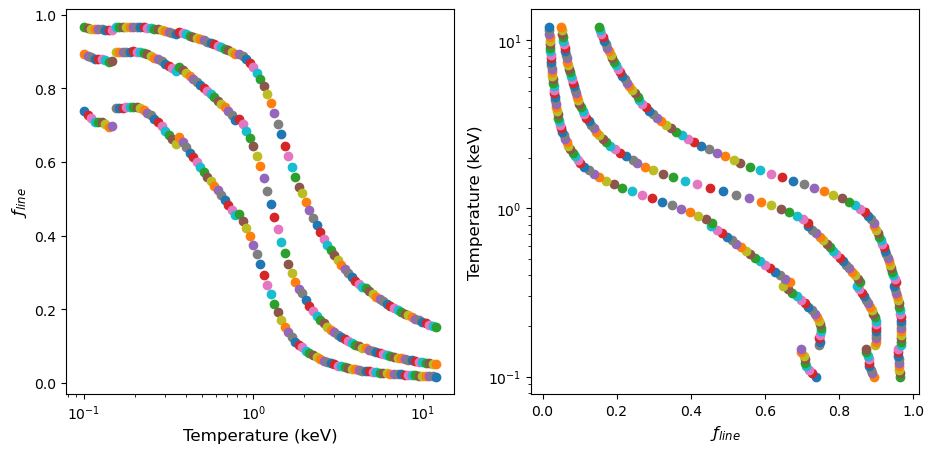

In [336]:
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

def f_line(telescope_name, temperature, mode, abundance):
    
    c__T = c_T(telescope_name, temperature, mode)
    l__T = l_T(telescope_name, temperature, mode)
    
    return l__T*abundance / (l__T*abundance + c__T)

plt.figure(figsize=(11,5))

tempps = np.logspace(np.log10(0.1), np.log10(12), 101)

moddde = 'npdot'

for ttt in tempps:
    
    #plt.subplot(121)
    #plt.scatter(ttt, f_line('Chandra/ACIS-OLD', ttt, 'flux', 0.1))
    #plt.xscale('log')
    #plt.ylabel('$ƒ_{line}$', fontsize = 12)
    #plt.xlabel('Temperature (keV)', fontsize = 12)

    for met in (0.1, 0.3, 1.0):
    
        plt.subplot(121)
        plt.scatter(ttt, f_line('Chandra/ACIS-OLD', ttt, moddde, met))
        plt.xscale('log')
        plt.ylabel('$ƒ_{line}$', fontsize = 12)
        plt.xlabel('Temperature (keV)', fontsize = 12)

        plt.subplot(122)
        plt.scatter(f_line('Chandra/ACIS-OLD', ttt, moddde, met), ttt)
        plt.yscale('log')
        plt.xlabel('$ƒ_{line}$', fontsize = 12)
        plt.ylabel('Temperature (keV)', fontsize = 12)